# Evaluating Open-source vs Closed-source LLMs and embedding models for LaVague

# Set up

First of all, we'll need to download all the required packages to run this notebook.


### Pre-requisites

Note: To run this notebook and evaluate all the models included inthis notebook, you will need the following API keys stored as secrets (see the key in the sidebar) in your Google Colab:

    OPENAI_API_KEY
    GOOGLE_API_KEY (Gemini API key)
    MISTRAL_API_KEY



In [ ]:
!pip install lavague datasets llama_index.embeddings.huggingface llama_index.embeddings.gemini llama_index.llms.mistralai lavague-contexts-gemini

Next, we will set our API keys as environment variables within the notebook environment.

For Google Colab users, you can set your API keys as secrets by clicking on the key icon in the side menu on the left-hand side.

In [12]:
import os

# Turn off telemetry
os.environ['TELEMETRY_VAR'] = "NONE"

# Check if running in Google Colab and set API keys accordingly
try:
    from google.colab import userdata
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    os.environ["MISTRAL_API_KEY"] = userdata.get("MISTRAL_API_KEY")
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
else:
    os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
    os.environ["MISTRAL_API_KEY"] = os.getenv('MISTRAL_API_KEY')
    os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')

## Retriever Evaluation

Let's start by evaluating the performance of the Retriever when used with three different embedding models, including local open-source and closed-source models.

In order to do this, we will download [the relevant dataset from `the-wave-250`](https://huggingface.co/datasets/BigAction/the-wave-250) which we curated for evaluating models used by LaVague.

We download `TheWaveMeta_rewrited.csv` file, which has all necessary pre-processing applied and is ready to be used for evaluating retrievers, and store its contents in a Panda's DataFrame.

This dataset has 250 rows of data, but we will just use 50 for the purposes of this demo - as running 250 rows will be slower and more costly!



In [8]:
from datasets import load_dataset
import pandas as pd

user = "BigAction"
dataset_name = "the-wave-250"
file_name = "TheWaveMeta_rewrited.csv"

dataset = load_dataset(f"{user}/{dataset_name}", data_files=file_name, split="train")

n_rows = 50
rephrased_df = pd.DataFrame(dataset)
rephrased_df = rephrased_df.iloc[:n_rows]

Now that we have our Panda's DataFrame containing our evaluation dataset, we are ready to start our tests.

First of all, we will need to initialize a RetrieverEvaluator object. This object has all the methods we need to conduct our retriever evaluations.

In [12]:
from lavague.core.evaluator import RetrieverEvaluator

retriever_evaluator = RetrieverEvaluator()

Now we will compare the retriever performance of the following three models:
- HuggingFace's local embedding model `BAAI/bge-small-en-v1.5`
- OpenAI's `text-embedding-3-small`
- Gemini's `text-embedding-004`

In [14]:
from lavague.core.retrievers import OpsmSplitRetriever
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.gemini import GeminiEmbedding
from lavague.drivers.selenium import SeleniumDriver
from llama_index.embeddings.openai import OpenAIEmbedding
import pandas as pd

driver = SeleniumDriver()

local_embedding = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
openai_embedding = OpenAIEmbedding(model="text-embedding-3-small")
gemini_embedding = gemini_embedding = GeminiEmbedding(model_name="models/text-embedding-004")

retrieved_data_opsm_local = retriever_evaluator.evaluate(
    OpsmSplitRetriever(driver, embedding=local_embedding), rephrased_df, "retrieved_data_opsm_local.csv"
)
retrieved_data_opsm_openai = retriever_evaluator.evaluate(
    OpsmSplitRetriever(driver, embedding=openai_embedding), rephrased_df, "retrieved_data_opsm_openai.csv"
)
retrieved_data_opsm_gemini = retriever_evaluator.evaluate(
    OpsmSplitRetriever(driver, embedding=gemini_embedding), rephrased_df, "retrieved_data_opsm_gemini.csv"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We can now visualize the results using the Evaluator's `compare` method which will show the precision, recall and time taken metrics for each embedding model.

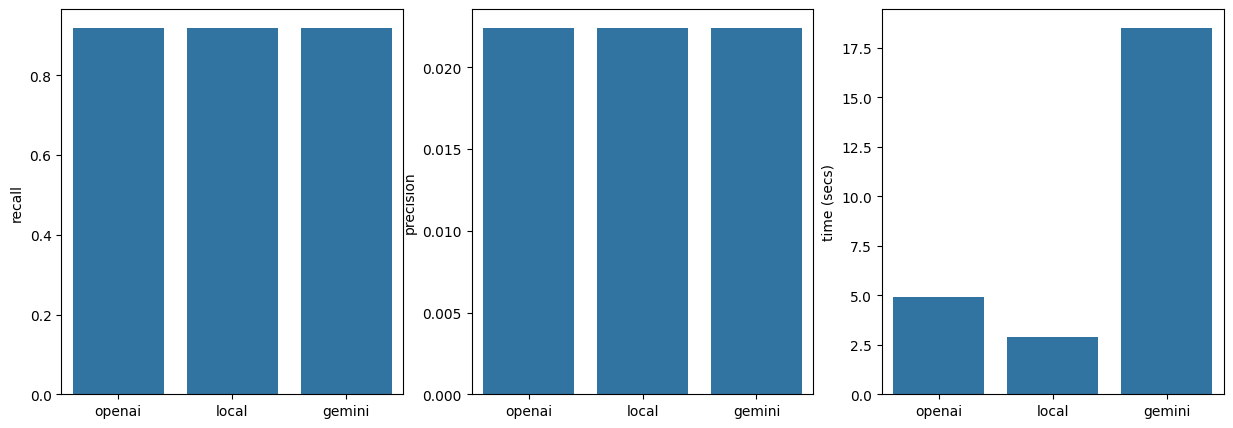

In [19]:
plot = retriever_evaluator.compare(
    {
        "openai": retrieved_data_opsm_openai,
        "local": retrieved_data_opsm_local,
        "gemini": retrieved_data_opsm_gemini
    }
)
plot.show()

We can see that performance is similar across all three embedding models, but that using a local embedding model is faster than using OpenAI or Gemini's models.

# LLM Evaluation

Next, we will compare the performance of Codestral vs two closed-source models: GPT4-o and Gemini's `gemini-1.5-flash-latest`.

For LLM evaluation, we will need to download the `TheWaveMeta_retreived.csv` file, which includes the retrieved nodes needed for the LLM to generate actions.

In [ ]:
from datasets import load_dataset
import pandas as pd


user = "BigAction"
dataset_name = "the-wave-250"
file_name = "TheWaveMeta_retrieved.csv"

dataset = load_dataset(f"{user}/{dataset_name}", data_files=file_name, split="train")

n_rows = 50
retrieved_df = pd.DataFrame(dataset)
retrieved_df = retrieved_df.iloc[:n_rows]

We can now intitialize our LLMEvaluator object.

In [27]:
from lavague.core.evaluator import LLMEvaluator

llm_evaluator = LLMEvaluator()

We will now initialize three Navigation Engine;s, using `codestral`, `GPT4-o` and `gemini-1.5-flash-latest` respectively.

In [ ]:
from lavague.contexts.openai import OpenaiContext
from lavague.contexts.gemini import GeminiContext
from lavague.core.navigation import NavigationEngine
from llama_index.llms.mistralai import MistralAI
from lavague.drivers.selenium import SeleniumDriver

driver = SeleniumDriver()

MISTRAL_API_KEY = os.environ["MISTRAL_API_KEY"]

mistral_llm = MistralAI(model="codestral-latest", api_key=MISTRAL_API_KEY)

mistral_engine = NavigationEngine(llm=mistral_llm, driver=SeleniumDriver())
openai_engine = NavigationEngine.from_context(OpenaiContext(), SeleniumDriver())
gemini_engine = NavigationEngine.from_context(GeminiContext(), SeleniumDriver())

We can now use the `evaluate` method to benchmark these models.

In [ ]:
mistral_results = llm_evaluator.evaluate(mistral_engine, retrieved_df, "mistral_results.csv")
openai_results = llm_evaluator.evaluate(openai_engine, retrieved_df, "openai_results.csv")
gemini_results = llm_evaluator.evaluate(gemini_engine, retrieved_df, "gemini_results.csv")

Finally, we will use the compare method to compare their performance.

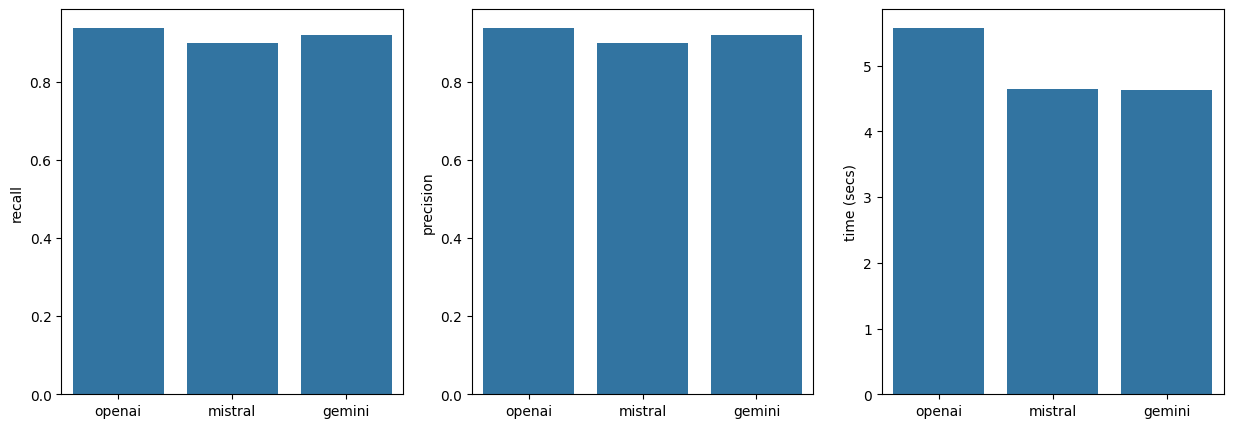

In [28]:
plot = llm_evaluator.compare(
    {
        "openai": openai_results,
        "mistral": mistral_results,
        "gemini": gemini_results
    }
)
plot.show()

While OpenAI is the best perfomer, Codestral's performance is very close behind its closed-source counterparts and shows itself to be a good option for local inference with LaVague.